In [1]:
import sunpy.io.special.genx
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
import astropy.io.fits as fits
import os

Open a few files we will want to use later.

In [2]:
suncet_base_path = os.environ.get('SunCET_base')

In [3]:
diffraction_psf_file = suncet_base_path + '/Software/suncet_data/filter_mesh_diffraction/suncet_diffraction_patterns_2k.fits'
diffraction_psf = fits.open(diffraction_psf_file)

In [4]:
scatter_psf_file = suncet_base_path + '/Software/suncet_data/mirror_scatter/suncet_mirror_scatter_psf_baffled.fits'
scatter_psf = fits.open(scatter_psf_file)

## Generate spectrally appropriate PSF

First we load a standard solar spectrum and the SunCET response so we can use our spectrally dependent diffraction PSF to generate a single appropriately averaged PSF.

In [5]:
spec_file = 'spectral_data/suncet_sample_spec.genx'
genx_data = sunpy.io.special.genx.read_genx(spec_file)
spec_wave = genx_data['LAMBDA'] * u.Angstrom
spec_spec = genx_data['SPECTRUM'] * u.ph * u.cm**(-2) * u.sr**(-1) * u.s**(-1) * u.Angstrom**(-1)

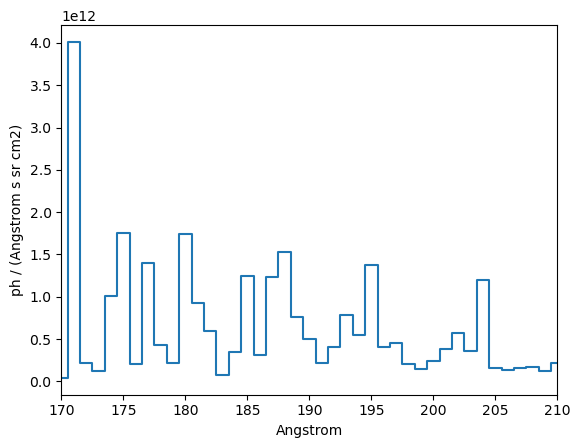

In [6]:
plt.step(spec_wave, spec_spec, where = 'mid')
plt.xlabel(spec_wave.unit.to_string())
plt.ylabel(spec_spec.unit.to_string())
plt.xlim(170, 210)
plt.show()

Now we load the SunCET spectral response function.

In [7]:
resp_file = 'spectral_data/SunCET_Spectral_Resp.genx'
resp_data = sunpy.io.special.genx.read_genx(resp_file)

Spectral response file is somewhat cavalierly made, so we have to just know which variable is which. Will improve this at some point, but we probably will just use a precooked PSF for deconvolution and skip this step, so maybe who cares?

In [8]:
resp_wave = resp_data['SAVEGEN0'] * u.Angstrom
resp_resp = resp_data['SAVEGEN1'] * u.cm**2 * u.DN/u.ph * u.sr/u.pix

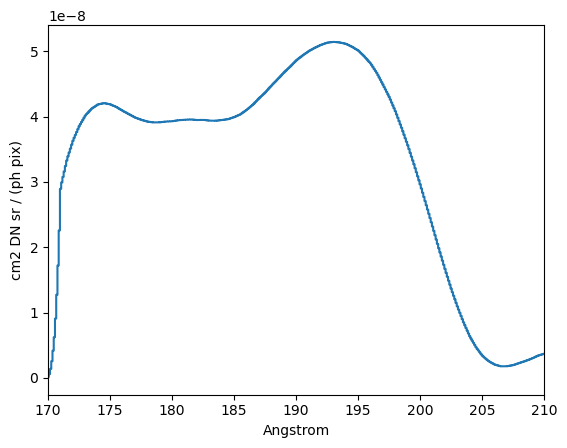

In [9]:
plt.step(resp_wave, resp_resp, where = 'mid')
plt.xlabel(resp_wave.unit.to_string())
plt.ylabel(resp_resp.unit.to_string())
plt.xlim(170, 210)
plt.show()

Now we interpolate the response function onto the spectral bins.

In [10]:
interp_func = interp1d(resp_wave, resp_resp, kind='linear', bounds_error=False, fill_value=0.)
interpolated_resp = interp_func(spec_wave) * u.cm**2 * u.DN/u.ph * u.sr/u.pix

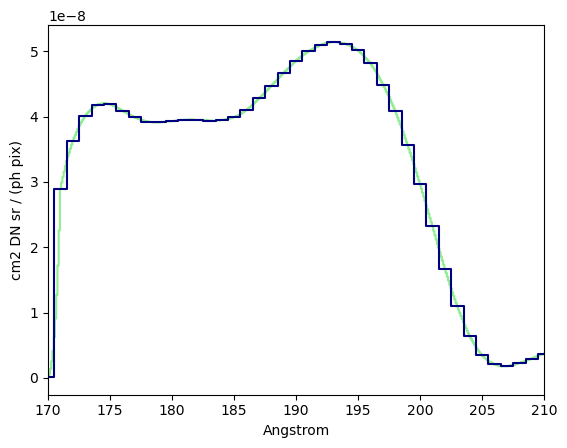

In [11]:
plt.step(resp_wave, resp_resp, where = 'mid', color = 'LightGreen')
plt.step(spec_wave, interpolated_resp, where = 'mid', color = 'Navy')
plt.xlabel(resp_wave.unit.to_string())
plt.ylabel(interpolated_resp.unit.to_string())
plt.xlim(170, 210)
plt.show()

Looks good. Now we can modulate the spectrum by this response function!

In [12]:
modulated_spec = interpolated_resp * spec_spec

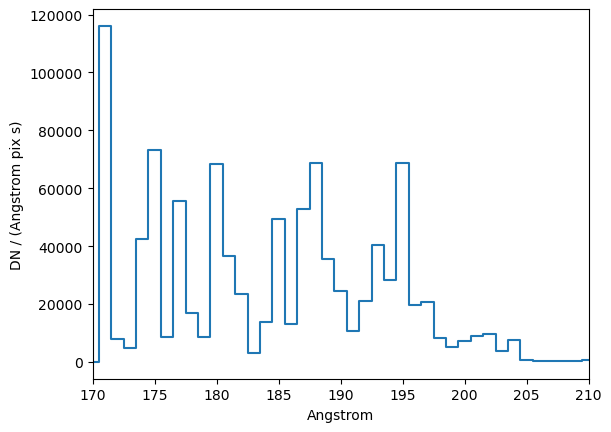

In [13]:
plt.step(spec_wave, modulated_spec, where = 'mid')
plt.xlabel(spec_wave.unit.to_string())
plt.ylabel(modulated_spec.unit.to_string())
plt.xlim(170, 210)
plt.show()

Wow, some of these are pretty high, but I guess this is why we use a very short exposure on the disk. Let's make our PSF.

In [14]:
num_diff_hdus = len(diffraction_psf)
merged_diffraction_psf_array = np.copy(diffraction_psf[0].data) * 0.
for n in range(num_diff_hdus):
    merged_diffraction_psf_array += modulated_spec[n].value * diffraction_psf[n].data
merged_diffraction_psf_array /= np.sum(modulated_spec.value)

Take a look to see what the averaging did compared to some individual PSFs.

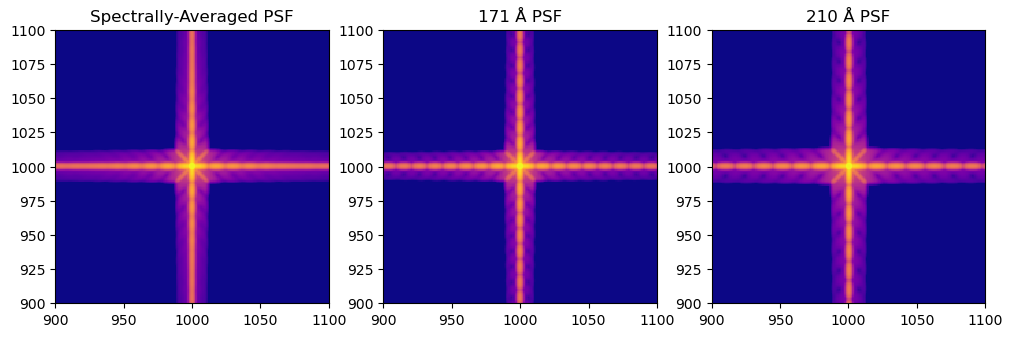

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow( np.log10(merged_diffraction_psf_array), cmap = 'plasma', vmin = -12, vmax = -2, interpolation = 'none', origin = 'lower')
ax[0].set_title('Spectrally-Averaged PSF')
ax[0].set_xlim(900, 1100)
ax[0].set_ylim(900, 1100)
ax[1].imshow( np.log10(diffraction_psf[1].data), cmap = 'plasma', vmin = -12, vmax = -2, interpolation = 'none', origin = 'lower')
ax[1].set_title(str(diffraction_psf[1].header['wavelnth']) + ' Å PSF')
ax[1].set_xlim(900, 1100)
ax[1].set_ylim(900, 1100)
ax[2].imshow( np.log10(diffraction_psf[40].data), cmap = 'plasma', vmin = -12, vmax = -2, interpolation = 'none', origin = 'lower')
ax[2].set_title(str(diffraction_psf[40].header['wavelnth']) + ' Å PSF')
ax[2].set_xlim(900, 1100)
ax[2].set_ylim(900, 1100)
plt.show()

## Load some Level 1 data to work on

Level 1 data is messed up right now, so currently I am using a Level-0 image and crude calibrating it by hand. Will fix later.

In [16]:
data_file = 'data/config_default_OBS_2023-02-14T17_00_00.000_300.fits'
data_hdul = fits.open(data_file)
dark_file = 'data/suncet_dark_img_2025-01-01T0000_v1.0.0.fits'
dark_hdul = fits.open(dark_file)
flat_file = 'data/suncet_flat_img_2025-01-01T0000_v1.0.0.fits'
flat_hdul = fits.open(flat_file)

Set up some config values to calibrate the image

In [17]:
naxis1 = int(data_hdul[0].header['NAXIS1'] - 1)
naxis2 = int(data_hdul[0].header['NAXIS2'] - 1)

detector_temp = -10. * u.deg_C
dark_current_mean = 20 * 2**((detector_temp.value - 20) / 5.5) * u.DN/u.s

exp_time_short = 0.035 * u.s
exp_time_long = 15 * u.s
short_exp_count = 10
long_exp_count = 3

inner_fov_radius = 1.33 # rsun
inner_fov_radius_px = inner_fov_radius * data_hdul[0].header['RSUN'] / data_hdul[0].header['CDELT1'] * u.pix
solar_disk_center = (data_hdul[0].header['CRPIX1'] - 1, data_hdul[0].header['CRPIX2'] - 1)
    
y_grid, x_grid = np.mgrid[:naxis1, :naxis2]
disk_mask = np.sqrt(((x_grid - solar_disk_center[0])**2 + (y_grid - solar_disk_center[1])**2)) <= inner_fov_radius_px.value

Apply calibration

In [18]:
print('Dark current:', dark_current_mean)

Dark current: 0.4560875330254521 DN / s


In [19]:
dark_frame = np.zeros((naxis2 + 1, naxis1 + 1)) + dark_current_mean.value

In [20]:
time_normalize_frame = np.zeros((naxis2 + 1, naxis1 + 1)) + exp_time_long.value
time_normalize_frame[np.where(disk_mask)] = exp_time_short.value

In [21]:
l1_data = data_hdul[0].data/time_normalize_frame - dark_frame

Check that the resulting image is pretty seamless

/tmp/ipykernel_66510/2832317183.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.nan_to_num(np.log10(l1_data), 0.0), cmap = 'Greys_r', vmin = 1.5, vmax = 6.5, origin = 'lower', interpolation = 'none')


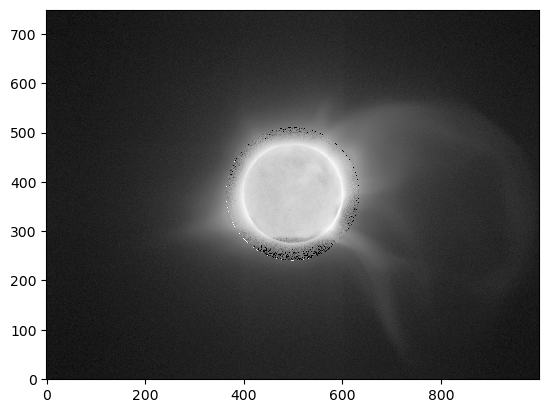

In [22]:
plt.imshow(np.nan_to_num(np.log10(l1_data), 0.0), cmap = 'Greys_r', vmin = 1.5, vmax = 6.5, origin = 'lower', interpolation = 'none')

## Do the deconvolutions

In [23]:
def rebin_interpolate(array, shape):
    zoom_factors = (shape[0] / array.shape[0], shape[1] / array.shape[1])
    return zoom(array, zoom_factors, order=1)  # order=1 for bilinear interpolation

### Filter mesh diffraction

In [24]:
def deconvolve_scatter(image, psf):
    psf_shape = psf.shape
    psf_padded = np.zeros((psf_shape[0] *2, psf_shape[1] * 2))
    psf_padded[psf_shape[0]//2: psf_shape[0]//2 + psf_shape[0], 
               psf_shape[1]//2: psf_shape[1]//2 + psf_shape[1]] = psf
    fPSF = np.fft.fft2(psf_padded)
    # fPSF = np.fft.fft2(psf)
    
    image_shape = image.shape
    image_padded = np.zeros((image_shape[0] *2, image_shape[1] * 2))
    image_padded[image_shape[0]//2: image_shape[0]//2 + image_shape[0], 
               image_shape[1]//2: image_shape[1]//2 + image_shape[1]] = image
    fImage = np.fft.fft2(image_padded)
    # fImage = np.fft.fft2(image)

    
    decon = np.real(np.fft.ifft2(fImage/fPSF))
    decon_shift = np.roll(decon, shift = (psf_shape[0], psf_shape[1]), axis = (0, 1))
    decon_cropped = decon_shift[psf_shape[0]//2: psf_shape[0]//2 + psf_shape[0], 
                                psf_shape[1]//2: psf_shape[1]//2 + psf_shape[1]]
    return(decon_cropped)

In [25]:
new_shape = (1000, 1000)
diff_psf_rebinned = rebin_interpolate(merged_diffraction_psf_array, new_shape)
diff_psf_rebinned_cropped = diff_psf_rebinned[125:-125, :] * 4. # factor of 4 accounts for rebinning effects to preserve normalization
decon_diff = deconvolve_scatter(l1_data, diff_psf_rebinned_cropped)

/tmp/ipykernel_66510/2884732744.py:2: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.log10(l1_data), cmap = 'Greys_r', vmin = 1.5, vmax = 3.5, origin = 'lower', interpolation = 'none')
/tmp/ipykernel_66510/2884732744.py:4: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.log10(decon_diff), cmap = 'Greys_r', vmin = 1.5, vmax = 3.5, origin = 'lower', interpolation = 'none')


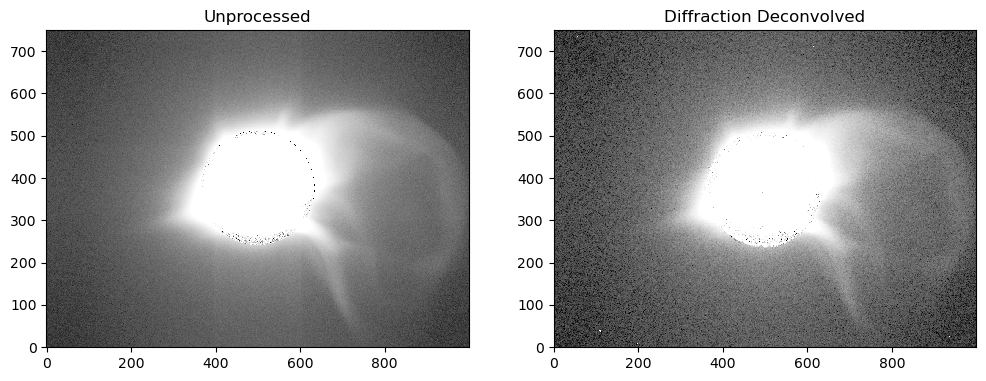

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.log10(l1_data), cmap = 'Greys_r', vmin = 1.5, vmax = 3.5, origin = 'lower', interpolation = 'none')
ax[0].set_title('Unprocessed')
ax[1].imshow(np.log10(decon_diff), cmap = 'Greys_r', vmin = 1.5, vmax = 3.5, origin = 'lower', interpolation = 'none')
ax[1].set_title('Diffraction Deconvolved')
plt.show()

### Mirror surface roughness scatter

Padded version of the deconvolution introduces some weird ringing at the edge of the image. Not sure why. If we do a no-padding version and get a better result.

In [27]:
def deconvolve_scatter_nopad(image, psf, alpha = 1, epsilon = 0.01):
    psf_shape = psf.shape
    fPSF = np.fft.fft2(psf)

    image_shape = image.shape
    fImage = np.fft.fft2(image)
    
    decon = np.real(np.fft.ifft2(fImage/fPSF))
    decon_shift = np.roll(decon, shift = (psf_shape[0]//2, psf_shape[1]//2), axis = (0, 1))
    return(decon_shift)

There's a weird ad hoc correction to the core size from what I would expect to get this deconvolution to work. I suspect it has to do with the rebinning, because the perfect number (for getting values close to zero in far field pixels) is about 0.25 -- and the rebin factor is 4. But This value seems to overdo the deconvolution and leaves a lot of noise. Aesthetically, I like a slightly larger number that leaves more signal out in the wings even if it's not photomtrically perfect.

In [28]:
correction_factor = 0.25

new_shape = (750, 1000)
scatter_psf_rebinned = rebin_interpolate(scatter_psf[0].data, new_shape)

TIS = np.sum(scatter_psf_rebinned)
scatter_psf_core = (1 - TIS) * correction_factor
scatter_psf_rebinned[375, 500] = scatter_psf_core
scatter_psf_rebinned /= np.sum(scatter_psf_rebinned)
decon_scatt = deconvolve_scatter_nopad(decon_diff, scatter_psf_rebinned)

/tmp/ipykernel_66510/1800256495.py:2: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.nan_to_num(np.log10(l1_data), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
/tmp/ipykernel_66510/1800256495.py:4: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.nan_to_num(np.log10(decon_scatt), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')


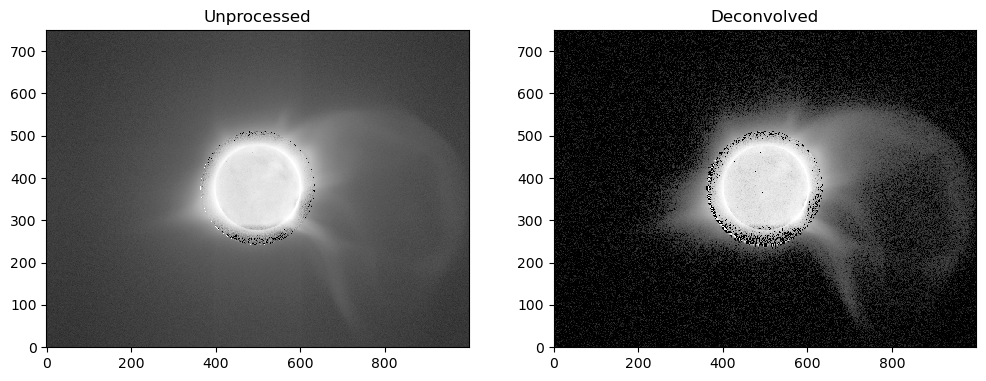

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(np.nan_to_num(np.log10(l1_data), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
ax[0].set_title('Unprocessed')
ax[1].imshow(np.nan_to_num(np.log10(decon_scatt), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
ax[1].set_title('Deconvolved')
plt.show()

Check some results to confirm the resulting image is well behaved. If the ratio isn't nearly one, something is wrong with the normalization of the PSF. 

Ideally I guess dark region in the deconvolved image would be exactly zero, but due to noise in the deconvolution in the inner part of the FOV that might not be achievable.

In [30]:
print('Ratio of deconvolved to raw L1 image:', np.sum(decon_scatt)/np.sum(l1_data))
print('Value of a random group of pixels that should be pretty dark in deconvolved:', np.mean(decon_scatt[80:100, 80:100]))
print('Value of a same pixels in L1 data:', np.mean(l1_data[80:100, 80:100]))

Ratio of deconvolved to raw L1 image: 1.0012270669151089
Value of a random group of pixels that should be pretty dark in deconvolved: 0.4224857011810271
Value of a same pixels in L1 data: 82.22462456717773


In [31]:
correction_factor = 0.4

new_shape = (750, 1000)
scatter_psf_rebinned = rebin_interpolate(scatter_psf[0].data, new_shape)

TIS = np.sum(scatter_psf_rebinned)
scatter_psf_core = (1 - TIS) * correction_factor
scatter_psf_rebinned[375, 500] = scatter_psf_core
scatter_psf_rebinned /= np.sum(scatter_psf_rebinned)
decon_scatt = deconvolve_scatter_nopad(decon_diff, scatter_psf_rebinned)

/tmp/ipykernel_66510/1800256495.py:2: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.nan_to_num(np.log10(l1_data), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
/tmp/ipykernel_66510/1800256495.py:4: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.nan_to_num(np.log10(decon_scatt), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')


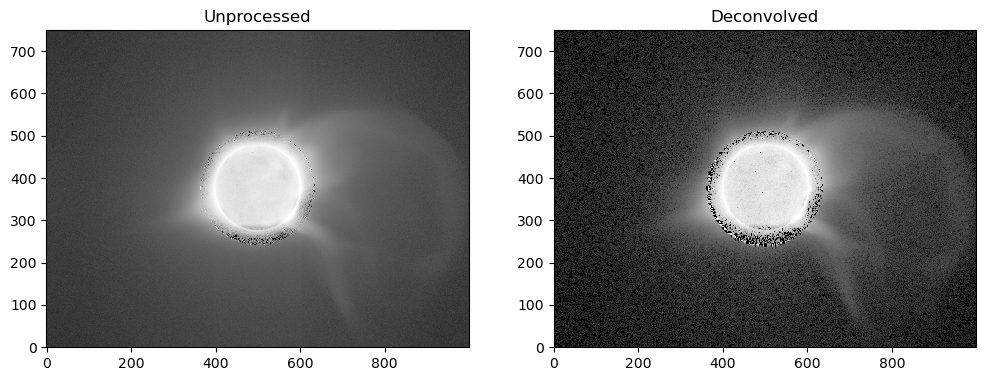

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(np.nan_to_num(np.log10(l1_data), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
ax[0].set_title('Unprocessed')
ax[1].imshow(np.nan_to_num(np.log10(decon_scatt), nan=0.0), cmap = 'Greys_r', vmin = 1., vmax = 6, origin = 'lower', interpolation = 'none')
ax[1].set_title('Deconvolved')
plt.show()

In [33]:
print('Ratio of deconvolved to raw L1 image:', np.sum(decon_scatt)/np.sum(l1_data))
print('Value of a random group of pixels that should be pretty dark in deconvolved:', np.mean(decon_scatt[80:100, 80:100]))
print('Value of a same pixels in L1 data:', np.mean(l1_data[80:100, 80:100]))

Ratio of deconvolved to raw L1 image: 1.0012270669151095
Value of a random group of pixels that should be pretty dark in deconvolved: 30.929111754616255
Value of a same pixels in L1 data: 82.22462456717773
